## Improved Single Match xG Infographic

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from highlight_text import fig_text

import utils.probability_functions as pf
from utils.cleaning import create_team_df, align_dfs, chance_quality

#### Load data

In [2]:
#load data
comp = 'gw32'
df = pd.read_csv(f'../../data/understat/liverpool/{comp}.csv')

#### Data preperation

In [3]:
# Create a df for each team (will only work as long as both teams took a shot)
df_home, df_away = create_team_df(df)

In [4]:
home_team, away_team = df_home['team'][0], df_away['team'][0]

Align dataframes so both spans from minute 0 to minute of last shot

In [5]:
df_home_final, df_home_final1, df_away_final, df_away_final1 = align_dfs(df, df_home, df_away)

In [6]:
home_min_final = list(df_home_final['minute'].unique())
away_min_final = list(df_away_final['minute'].unique())

home_cum_xG_final = np.array(df_home_final1)
away_cum_xG_final = np.array(df_away_final1)

#home_min_final = list(home_min_final)
#away_min_final = list(away_min_final)

#home_cum_xG_final = list(home_cum_xG_final)
#away_cum_xG_final = list(away_cum_xG_final)

#### Calculate scoreline probabilities

In [7]:
#find total xG
home_total_xG = round(home_cum_xG_final[-1], 2)
away_total_xG = round(away_cum_xG_final[-1], 2)

# Get probability of all scorelines from 0-0 to 9-9
home_goal_probs, away_goal_probs, scoreline_probs = pf.score_probability(home_total_xG, away_total_xG, num_goals=10)

Visualize goal probabilities

In [8]:
# Create xs and ys for bar plots 
home_xs, home_ys = zip(*home_goal_probs)
away_xs, away_ys = zip(*away_goal_probs)

# Get number of goals for each team
home_goals = len(df_home[df_home['result'] == 'Goal'])
away_goals = len(df_away[df_away['result'] == 'Goal'])

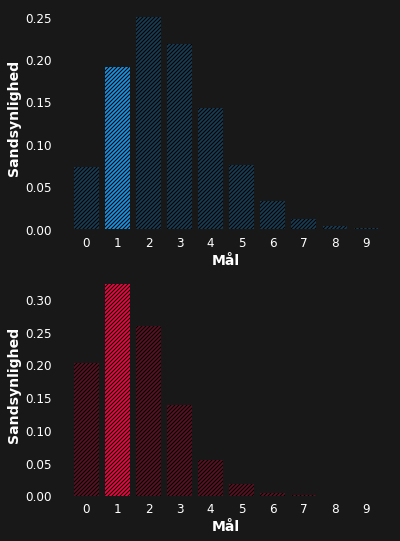

In [9]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color = '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (6,9))
fig.set_facecolor(facecolor)
ax1.set_facecolor(facecolor)
ax2.set_facecolor(facecolor)


# ---------- ax1 -------------- #
ax1.bar(home_xs, home_ys,
        color=home_color, zorder=10, hatch=3*'//', alpha=0.3)
for i in home_xs:
    if i == home_goals:
        ax1.bar(i, home_ys[i],
        color=home_color, zorder=10, hatch=3*'//', alpha=1)
#set up our base layer
ax1.tick_params(axis='x', colors='w', labelsize=12)
ax1.set_xticks(home_xs)
ax1.tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
ax1.tick_params(axis='both', which='both', left=False, bottom=False)
ax1.set_frame_on(False)

# Set labels and text
ax1.set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
ax1.set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)


# ---------- ax2 -------------- #
ax2.bar(away_xs, away_ys,
        color=away_color, zorder=10, hatch=3*'//', alpha=0.3)
for i in away_xs:
    if i == away_goals:
        ax2.bar(i, away_ys[i],
        color=away_color, zorder=10, hatch=3*'//', alpha=1)

#set up our base layer
ax2.tick_params(axis='x', colors='w', labelsize=12)
ax2.set_xticks(away_xs)
ax2.tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
ax2.tick_params(axis='both', which='both', left=False, bottom=False)
ax2.set_frame_on(False)

# Set labels and text
ax2.set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
ax2.set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)


plt.show()

Visualize scoreline probabilities

In [10]:
for i in range(3):
    print(scoreline_probs[i])

[(2, 1), 0.08071790027155822]
[(3, 1), 0.0704936329038275]
[(2, 2), 0.06457432021724659]


#### Calculate win, loss and draw probabilities

In [11]:
home_prob, away_prob, draw_prob = pf.win_loss_draw_probs(scoreline_probs)

# Concat into list
home_away_draw_probs = pd.DataFrame({'outcomes': ['home', 'away', 'draw'], 'probs': [home_prob, away_prob, draw_prob]})

Visualize win, loss, draw probabilities

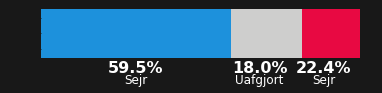

In [12]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, ax = plt.subplots(figsize = (6,1))
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

#set up our base layer
ax.tick_params(axis='x', colors=facecolor, labelsize=12)
ax.tick_params(axis='y', colors=facecolor, labelsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Plot bars
home = ax.barh(0.5, home_away_draw_probs['probs'][0], color=home_color)
draw = ax.barh(0.5, home_away_draw_probs['probs'][1],
               left=home_away_draw_probs['probs'][0], color=text_color)
away = ax.barh(0.5, home_away_draw_probs['probs'][2],
               left=home_away_draw_probs['probs'][0]+home_away_draw_probs['probs'][1], color=away_color)

# Set texts
# Home
ax.text(x=home_prob/2, y=-0.12, s=f'{round(home_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob/2, y=-0.3, s=f'Sejr',
        color='w', ha='center', size=12)
# Draw
ax.text(x=home_prob+draw_prob/2, y=-0.12, s=f'{round(draw_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob+draw_prob/2, y=-0.3, s=f'Uafgjort',
        color='w', ha='center', size=12)
# Away
ax.text(x=home_prob+draw_prob+away_prob/2, y=-0.12, s=f'{round(away_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob+draw_prob+away_prob/2, y=-0.3, s=f'Sejr',
        color='w', ha='center', size=12)

#plt.savefig('output/win_probability_viz.png',
#            dpi=600, bbox_inches='tight')

plt.show()

In [13]:
home_xs_scatter = np.random.uniform(low=0, high=home_prob, size=(len(df_home),))
home_ys_scatter = np.random.uniform(low=0, high=1, size=(len(df_home),))

away_xs_scatter = np.random.uniform(low=home_prob+draw_prob, high=home_prob+draw_prob+away_prob, size=(len(df_away),))
away_ys_scatter = np.random.uniform(low=0, high=1, size=(len(df_away),))

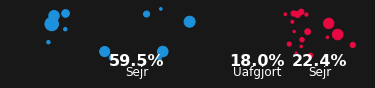

In [14]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, ax = plt.subplots(figsize = (6,1))
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

#set up our base layer
ax.tick_params(axis='x', colors=facecolor, labelsize=12)
ax.tick_params(axis='y', colors=facecolor, labelsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Plot bars
home = ax.scatter(home_xs_scatter, home_ys_scatter, color=home_color, s=df_home['xG']*300)
away = ax.scatter(away_xs_scatter, away_ys_scatter, color=away_color, s=df_away['xG']*300)

                  
                  
#away = ax.barh(0.5, home_away_draw_probs['probs'][2],
#               left=home_away_draw_probs['probs'][0]+home_away_draw_probs['probs'][1], color=away_color)

# Set texts
# Home
ax.text(x=home_prob/2, y=-0.12, s=f'{round(home_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob/2, y=-0.3, s=f'Sejr',
        color='w', ha='center', size=12)
# Draw
ax.text(x=home_prob+draw_prob/2, y=-0.12, s=f'{round(draw_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob+draw_prob/2, y=-0.3, s=f'Uafgjort',
        color='w', ha='center', size=12)
# Away
ax.text(x=home_prob+draw_prob+away_prob/2, y=-0.12, s=f'{round(away_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob+draw_prob+away_prob/2, y=-0.3, s=f'Sejr',
        color='w', ha='center', size=12)

#plt.savefig('output/win_probability_viz.png',
#            dpi=600, bbox_inches='tight')

plt.show()

#### Regular xG Race Chart

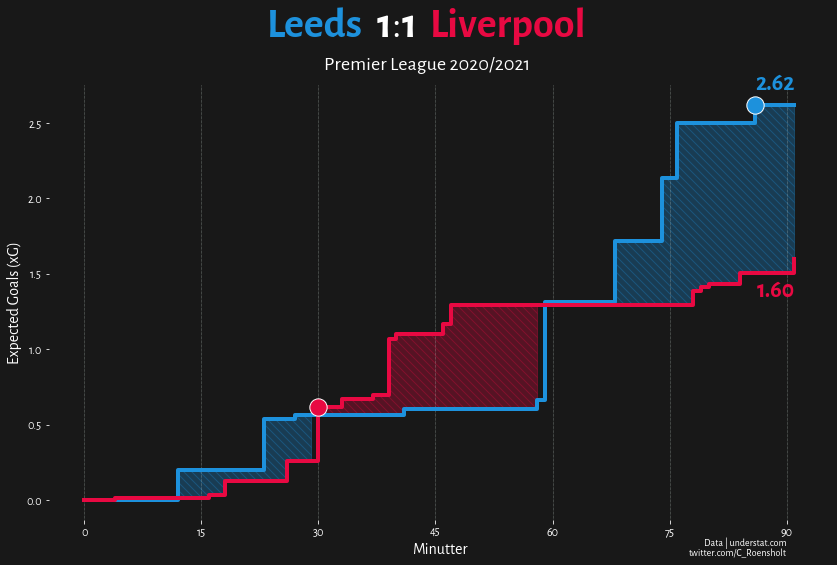

In [15]:
mpl.rcParams['font.family'] = 'Alegreya Sans'

lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, ax = plt.subplots(figsize = (14,8))
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

#set up our base layer
ax.tick_params(axis='x', colors='white', labelsize=12)
ax.tick_params(axis='y', colors='white', labelsize=12)

#set grid
ax.grid(ls='dotted', lw=.5, color='#c7d5cc', axis='x', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
plt.xticks([0,15,30,45,60,75,90, 105])


#plot the step graphs
ax.plot(home_min_final, home_cum_xG_final, drawstyle='steps-post',
        color=home_color, label=f'{home_team}', linewidth=4)
ax.plot(away_min_final, away_cum_xG_final, drawstyle='steps-post',
        color=away_color, label=f'{away_team}', linewidth=4)

#fill below line plot
#minutes = list(sorted(np.concatenate([home_min, away_min])))
home_where = (np.array(home_cum_xG_final) > np.array(away_cum_xG_final))
ax.fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
                where=home_where, #interpolate=True,
                color=home_color, alpha=0.3, hatch=3*'\\')
away_where = (np.array(home_cum_xG_final) < np.array(away_cum_xG_final))
ax.fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
                where=away_where, #interpolate=True,
                color=away_color, alpha=0.3, hatch=3*'\\')


#plot home goals
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'Goal':
        plt.scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, edgecolor='white', label='Mål')
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'OwnGoal':
        plt.scatter(df_away_final['minute'][i], df_home_final1['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, edgecolor='white', label='Mål')

#plot away goals
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'Goal':
        plt.scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, edgecolor='white', label='Mål')
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'OwnGoal':
        plt.scatter(df_home_final['minute'][i], df_away_final1['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, edgecolor='white', label='Mål')

#set title and text
home_goals = len(df_home[df_home['result'] == 'Goal'])
home_goals += len(df_away[df_away['result'] == 'OwnGoal'])
away_goals = len(df_away[(df_away['result'] == 'Goal')])
away_goals += len(df_home[df_home['result'] == 'OwnGoal'])


#fig.suptitle(f'{home_team}  {home_goals}:{away_goals}  {away_team}', 
#            fontsize=28, color='white')

fig_text(x=0.5, y=0.95, s = f'<{home_team}>  <{home_goals}>:<{away_goals}>  <{away_team}>', 
         fontsize=42, color='white', ha='center', highlight_colors=[home_color, 'w', 'w', away_color],
         highlight_weights='bold')
fig_text(x=0.5, y=0.9, s = f'Premier League 2020/2021', 
         fontsize=20, color='white', ha='center', highlight_colors=['w'], highlight_weights='bold')


#add home team total xG
ax.text(home_min_final[-1], home_cum_xG_final[-1]+0.1, s='{:.2f}'.format(home_total_xG),
        color=home_color, fontsize=24, fontweight='bold', ha='right')
ax.text(away_min_final[-1], away_cum_xG_final[-1]-0.25, s='{:.2f}'.format(away_total_xG),
        color=away_color, fontsize=24, fontweight='bold', ha='right')

ax.text(90, -0.3, s='Data | understat.com', ha='right',
        fontsize=10, fontstyle='normal', color='white')
ax.text(90, -0.37, s='twitter.com/C_Roensholt', fontsize=10, fontstyle='normal', color='white', ha='right')



ax.set_xlabel('Minutter', color='white', fontsize=16)
ax.set_ylabel('Expected Goals (xG)', color='white', fontsize=16)

#plt.savefig(f'output/{home_team}_vs_{away_team}_xG_Infographic_{comp}.png', dpi=600, 
#            bbox_inches='tight', facecolor=facecolor, edgecolor='none')

plt.show()

#### The improved match xG Infographic

In [20]:
images = [
    r"team_logos\Arsenal.png",
    r"team_logos\AstonVilla.png",
    r"team_logos\Brighton.png",
    r"team_logos\Burnley.png",
    r"team_logos\Chelsea.png",
    r"team_logos\CrystalPalace.png",
    r"team_logos\Everton.png",
    r"team_logos\Fulham.png",
    r"team_logos\Leeds.png",
    r"team_logos\Leicester.png",
    r"team_logos\Liverpool.png",
    r"team_logos\ManchesterCity.png",
    r"team_logos\ManchesterUnited.png",
    r"team_logos\Newcastle.png",
    r"team_logos\ShieffieldUnited.png",
    r"team_logos\Southampton.png",
    r"team_logos\Tottenham.png",
    r"team_logos\WestBrom.png",
    r"team_logos\WestHam.png",
    r"team_logos\Wolves.png"
]

In [21]:
def imscatter(x, y, image, ax=None, zoom=1):
    """ Function to plot the team crests (stackoverflow.com/questions/35651932/plotting-img-with-matplotlib/35651933)"""
    
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

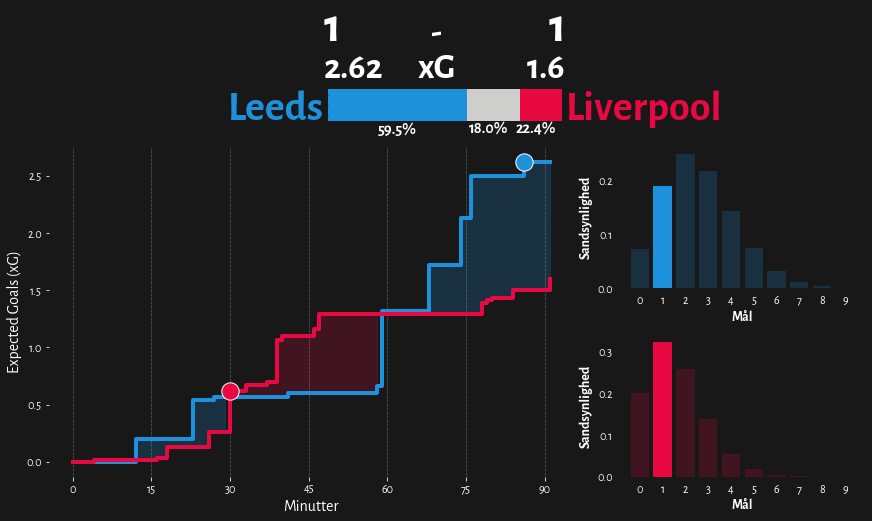

In [22]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

layout = [[1,1,1],
          [2,2,3],
          [2,2,4]]

fig, axd = plt.subplot_mosaic(
    '''
    .A.
    BBC
    BBD
    ''',
    constrained_layout=True, figsize=(12,6),
    gridspec_kw={'height_ratios':[0.1, 0.4, 0.4]})
                 #'width_ratios':[0.15, 0.5, 0.25]})


#ax1, ax2, ax3, ax4 = axd.values()
fig.set_facecolor(facecolor)

# ------------- ax 1 -------------- #
axd['A'].set_facecolor(facecolor)
#set up our base layer
axd['A'].tick_params(axis='x', colors=facecolor, labelsize=12)
axd['A'].tick_params(axis='y', colors=facecolor, labelsize=12)

axd['A'].spines["top"].set_visible(False)
axd['A'].spines["right"].set_visible(False)
axd['A'].spines["bottom"].set_visible(False)
axd['A'].spines["left"].set_visible(False)

# Plot bars
home = axd['A'].barh(0.5, home_away_draw_probs['probs'][0], color=home_color)
draw = axd['A'].barh(0.5, home_away_draw_probs['probs'][1],
               left=home_away_draw_probs['probs'][0], color=text_color)
away = axd['A'].barh(0.5, home_away_draw_probs['probs'][2],
               left=home_away_draw_probs['probs'][0]+home_away_draw_probs['probs'][1], color=away_color)

# Set texts
# Home
axd['A'].text(x=home_prob/2, y=-0.2, s=f'{round(home_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
#ax1.text(x=home_prob/2, y=-0.3, s=f'Sejr',
#        color='w', ha='center', size=12)
# Draw
axd['A'].text(x=home_prob+draw_prob/2, y=-0.2, s=f'{round(draw_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
#ax1.text(x=home_prob+draw_prob/2, y=-0.3, s=f'Uafgjort',
#        color='w', ha='center', size=12)
# Away
axd['A'].text(x=home_prob+draw_prob+away_prob/2, y=-0.2, s=f'{round(away_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
#ax1.text(x=home_prob+draw_prob+away_prob/2, y=-0.3, s=f'Sejr',
#        color='w', ha='center', size=12)


# ------------- ax 2 -------------- #
axd['B'].set_facecolor(facecolor)
#set up our base layer
axd['B'].tick_params(axis='x', colors='white', labelsize=12)
axd['B'].tick_params(axis='y', colors='white', labelsize=12)

axd['B'].set_frame_on(False)

#set grid
axd['B'].grid(ls='dotted', lw=.5, color='#c7d5cc', axis='x', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        axd['B'].spines[x].set_visible(False)
axd['B'].set_xticks([0,15,30,45,60,75,90, 105])


#plot the step graphs
axd['B'].plot(home_min_final, home_cum_xG_final, drawstyle='steps-post',
        color=home_color, label=f'{home_team}', linewidth=4)
axd['B'].plot(away_min_final, away_cum_xG_final, drawstyle='steps-post',
        color=away_color, label=f'{away_team}', linewidth=4)

#fill below line plot
#minutes = list(sorted(np.concatenate([home_min, away_min])))
home_where = (np.array(home_cum_xG_final) > np.array(away_cum_xG_final))
axd['B'].fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
                where=home_where, #interpolate=True,
                color=home_color, alpha=0.2)#, hatch=3*'//')
away_where = (np.array(home_cum_xG_final) < np.array(away_cum_xG_final))
axd['B'].fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
                where=away_where, #interpolate=True,
                color=away_color, alpha=0.2)#, hatch=3*'//')


#plot home goals
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'Goal':
        axd['B'].scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, edgecolor='white', label='Mål')
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'OwnGoal':
        axd['B'].scatter(df_away_final['minute'][i], df_home_final1['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, edgecolor='white', label='Mål')

#plot away goals
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'Goal':
        axd['B'].scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, edgecolor='white', label='Mål')
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'OwnGoal':
        axd['B'].scatter(df_home_final['minute'][i], df_away_final1['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, edgecolor='white', label='Mål')

#set title and text
home_goals = len(df_home[df_home['result'] == 'Goal'])
home_goals += len(df_away[df_away['result'] == 'OwnGoal'])
away_goals = len(df_away[(df_away['result'] == 'Goal')])
away_goals += len(df_home[df_home['result'] == 'OwnGoal'])


#add home team total xG

#axd['B'].text(90, -0.38, s='Data | understat.com', ha='right',
#        fontsize=10, fontstyle='normal', color='white')
#axd['B'].text(90, -0.45, s='twitter.com/C_Roensholt', fontsize=10, fontstyle='normal', color='white', ha='right')



axd['B'].set_xlabel('Minutter', color='white', fontsize=16)
axd['B'].set_ylabel('Expected Goals (xG)', color='white', fontsize=16)



# ------------- ax C -------------- #
axd['C'].bar(home_xs, home_ys,
        color=home_color, zorder=10, alpha=0.2)
for i in home_xs:
    if i == home_goals:
        axd['C'].bar(i, home_ys[i],
        color=home_color, zorder=10, alpha=1)
#set up our base layer
axd['C'].tick_params(axis='x', colors='w', labelsize=12)
axd['C'].set_xticks(home_xs)
axd['C'].tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
axd['C'].tick_params(axis='both', which='both', left=False, bottom=False)
axd['C'].set_frame_on(False)

# Set labels and text
axd['C'].set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
axd['C'].set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)



# ------------- ax D -------------- #
axd['D'].set_facecolor(facecolor)

axd['D'].bar(away_xs, away_ys,
             color=away_color, zorder=10, alpha=0.2)
for i in away_xs:
    if i == away_goals:
        axd['D'].bar(i, away_ys[i],
        color=away_color, zorder=10, alpha=1)

#set up our base layer
axd['D'].tick_params(axis='x', colors='w', labelsize=12)
axd['D'].set_xticks(away_xs)
axd['D'].tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
axd['D'].tick_params(axis='both', which='both', left=False, bottom=False)
axd['D'].set_frame_on(False)

# Set labels and text
axd['D'].set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
axd['D'].set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)



# Add home and away team names
fig_text(x=0.37, y=0.90, s = f'<{home_team}>', 
         fontsize=42, color='white', ha='right', highlight_colors=[home_color],
         highlight_weights='bold')
fig_text(x=0.65, y=0.90, s = f'<{away_team}>', 
         fontsize=42, color='white', ha='left', highlight_colors=[away_color],
         highlight_weights='bold')

# Add home and away goals
fig_text(x=0.37, y=1.08, s = f'{home_goals}', 
         fontsize=48, color='white', ha='left', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.65, y=1.08, s = f'{away_goals}', 
         fontsize=48, color='white', ha='right', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add home and away xG totals
fig_text(x=0.37, y=1, s = f'<{home_total_xG}>', 
         fontsize=36, color='white', ha='left', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.65, y=1, s = f'<{away_total_xG}>', 
         fontsize=36, color='white', ha='right', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add text between xG and goals
fig_text(x=0.5, y=1.08, s = '-', 
         fontsize=36, color='white', ha='center', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.5, y=1, s = 'xG', 
         fontsize=36, color='white', ha='center', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add logos
#home_logo = imscatter(x=0.3, y=1.05, image=images[8], ax=axd['A'], zoom=1)
#away_logo = 

#fig_text(x=0.5, y=0.9, s = f'Premier League 2020/2021', 
#         fontsize=20, color='white', ha='center', highlight_colors=['w'], highlight_weights='bold')

plt.show()

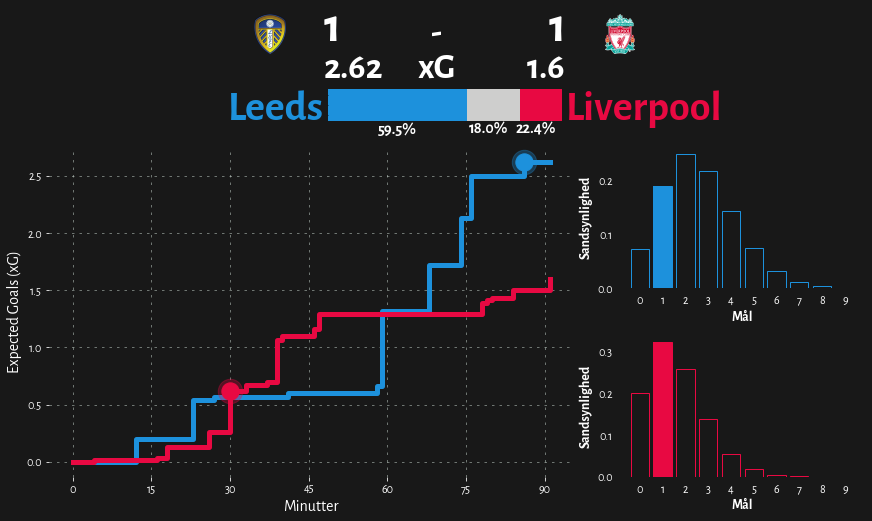

In [56]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

layout = [[1,1,1],
          [2,2,3],
          [2,2,4]]

fig, axd = plt.subplot_mosaic(
    '''
    .A.
    BBC
    BBD
    ''',
    constrained_layout=True, figsize=(12,6),
    gridspec_kw={'height_ratios':[0.1, 0.4, 0.4]})
                 #'width_ratios':[0.15, 0.5, 0.25]})


#ax1, ax2, ax3, ax4 = axd.values()
fig.set_facecolor(facecolor)

# ------------- ax 1 -------------- #
axd['A'].set_facecolor(facecolor)
#set up our base layer
axd['A'].tick_params(axis='x', colors=facecolor, labelsize=12)
axd['A'].tick_params(axis='y', colors=facecolor, labelsize=12)

axd['A'].spines["top"].set_visible(False)
axd['A'].spines["right"].set_visible(False)
axd['A'].spines["bottom"].set_visible(False)
axd['A'].spines["left"].set_visible(False)

# Plot bars
home = axd['A'].barh(0.5, home_away_draw_probs['probs'][0], color=home_color)
draw = axd['A'].barh(0.5, home_away_draw_probs['probs'][1],
               left=home_away_draw_probs['probs'][0], color=text_color)
away = axd['A'].barh(0.5, home_away_draw_probs['probs'][2],
               left=home_away_draw_probs['probs'][0]+home_away_draw_probs['probs'][1], color=away_color)

# Set texts
# Home
axd['A'].text(x=home_prob/2, y=-0.2, s=f'{round(home_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
#ax1.text(x=home_prob/2, y=-0.3, s=f'Sejr',
#        color='w', ha='center', size=12)
# Draw
axd['A'].text(x=home_prob+draw_prob/2, y=-0.2, s=f'{round(draw_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
#ax1.text(x=home_prob+draw_prob/2, y=-0.3, s=f'Uafgjort',
#        color='w', ha='center', size=12)
# Away
axd['A'].text(x=home_prob+draw_prob+away_prob/2, y=-0.2, s=f'{round(away_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
#ax1.text(x=home_prob+draw_prob+away_prob/2, y=-0.3, s=f'Sejr',
#        color='w', ha='center', size=12)


# ------------- ax 2 -------------- #
axd['B'].set_facecolor(facecolor)
#set up our base layer
axd['B'].tick_params(axis='x', colors='white', labelsize=12)
axd['B'].tick_params(axis='y', colors='white', labelsize=12)

axd['B'].set_frame_on(False)

#set grid
axd['B'].grid(ls=(0, (5, 10)), lw=.5, color='#c7d5cc', axis='both', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        axd['B'].spines[x].set_visible(False)
axd['B'].set_xticks([0,15,30,45,60,75,90, 105])


#plot the step graphs
axd['B'].plot(home_min_final, home_cum_xG_final, drawstyle='steps-post',
        color=home_color, label=f'{home_team}', linewidth=5)

axd['B'].plot(away_min_final, away_cum_xG_final, drawstyle='steps-post',
        color=away_color, label=f'{away_team}', linewidth=5)

#fill below line plot
#minutes = list(sorted(np.concatenate([home_min, away_min])))
#home_where = (np.array(home_cum_xG_final) > np.array(away_cum_xG_final))
#axd['B'].fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
#                where=home_where, #interpolate=True,
#                color=home_color, alpha=0.2)#, hatch=3*'//')
#away_where = (np.array(home_cum_xG_final) < np.array(away_cum_xG_final))
#axd['B'].fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
#                where=away_where, #interpolate=True,
#                color=away_color, alpha=0.2)#, hatch=3*'//')


#plot home goals
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'Goal':
        axd['B'].scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, label='Mål')
        axd['B'].scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
            s=600, zorder=9, facecolor=home_color, alpha=0.3)
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'OwnGoal':
        axd['B'].scatter(df_away_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, label='Mål')
        axd['B'].scatter(df_away_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=600, zorder=9, facecolor=home_color, alpha=0.3)
        
#plot away goals
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'Goal':
        axd['B'].scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, label='Mål')
        axd['B'].scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=600, zorder=9, facecolor=away_color, alpha=0.3)
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'OwnGoal':
        axd['B'].scatter(df_home_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, label='Mål')
        axd['B'].scatter(df_home_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=600, zorder=9, facecolor=away_color, alpha=0.3)

#set title and text
home_goals = len(df_home[df_home['result'] == 'Goal'])
home_goals += len(df_away[df_away['result'] == 'OwnGoal'])
away_goals = len(df_away[(df_away['result'] == 'Goal')])
away_goals += len(df_home[df_home['result'] == 'OwnGoal'])


#add home team total xG

#axd['B'].text(90, -0.38, s='Data | understat.com', ha='right',
#        fontsize=10, fontstyle='normal', color='white')
#axd['B'].text(90, -0.45, s='twitter.com/C_Roensholt', fontsize=10, fontstyle='normal', color='white', ha='right')

axd['B'].set_xlabel('Minutter', color='white', fontsize=16)
axd['B'].set_ylabel('Expected Goals (xG)', color='white', fontsize=16)



# ------------- ax C -------------- #
axd['C'].bar(home_xs, home_ys,
        facecolor=facecolor, edgecolor=home_color, zorder=10, alpha=1)
for i in home_xs:
    if i == home_goals:
        axd['C'].bar(i, home_ys[i],
        color=home_color, zorder=10, alpha=1)

#set up our base layer
axd['C'].tick_params(axis='x', colors='w', labelsize=12)
axd['C'].set_xticks(home_xs)
axd['C'].tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
axd['C'].tick_params(axis='both', which='both', left=False, bottom=False)
axd['C'].set_frame_on(False)

# Set labels and text
axd['C'].set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
axd['C'].set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)



# ------------- ax D -------------- #
axd['D'].set_facecolor(facecolor)

axd['D'].bar(away_xs, away_ys,
             facecolor=facecolor, edgecolor=away_color, zorder=10, alpha=1)
for i in away_xs:
    if i == away_goals:
        axd['D'].bar(i, away_ys[i],
        color=away_color, zorder=10, alpha=1)

#set up our base layer
axd['D'].tick_params(axis='x', colors='w', labelsize=12)
axd['D'].set_xticks(away_xs)
axd['D'].tick_params(axis='y', colors='w', labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
axd['D'].tick_params(axis='both', which='both', left=False, bottom=False)
axd['D'].set_frame_on(False)

# Set labels and text
axd['D'].set_xlabel('Mål',
               color='w', fontweight='bold', size=14)
axd['D'].set_ylabel('Sandsynlighed',
               color='w', fontweight='bold', size=14)



# Add home and away team names
fig_text(x=0.37, y=0.90, s = f'<{home_team}>', 
         fontsize=42, color='white', ha='right', highlight_colors=[home_color],
         highlight_weights='bold')
fig_text(x=0.65, y=0.90, s = f'<{away_team}>', 
         fontsize=42, color='white', ha='left', highlight_colors=[away_color],
         highlight_weights='bold')

# Add home and away goals
fig_text(x=0.37, y=1.08, s = f'{home_goals}', 
         fontsize=48, color='white', ha='left', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.65, y=1.08, s = f'{away_goals}', 
         fontsize=48, color='white', ha='right', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add home and away xG totals
fig_text(x=0.37, y=1, s = f'<{home_total_xG}>', 
         fontsize=36, color='white', ha='left', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.65, y=1, s = f'<{away_total_xG}>', 
         fontsize=36, color='white', ha='right', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add text between xG and goals
fig_text(x=0.5, y=1.08, s = '-', 
         fontsize=36, color='white', ha='center', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')
fig_text(x=0.5, y=1, s = 'xG', 
         fontsize=36, color='white', ha='center', highlight_colors=['w'],
         highlight_weights='bold', fontweight='bold')

# Add logos
home_logo = Image.open(f'team_logos/{home_team}.png')
height = home_logo.size[1]
home_logo = np.array(home_logo).astype(float) / 255
fig.figimage(home_logo, 250, fig.bbox.ymax - height + 75)

away_logo = Image.open(f'team_logos/{away_team}.png')
height = away_logo.size[1]
away_logo = np.array(away_logo).astype(float) / 255
fig.figimage(away_logo, 600, fig.bbox.ymax - height + 75)
#home_logo = imscatter(x=-.1, y=1.05, image=images[8], ax=axd['A'], zoom=1)
#away_logo = 

#fig_text(x=0.5, y=0.9, s = f'Premier League 2020/2021', 
#         fontsize=20, color='white', ha='center', highlight_colors=['w'], highlight_weights='bold')

plt.show()